In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from matplotlib import style
from PIL import Image
from wordcloud import WordCloud

In [2]:
# Import all the dialogues from episode 4
files_list = ['./data/star_wars_movies_scripts/SW_EpisodeIV.txt',
              './data/star_wars_movies_scripts/SW_EpisodeV.txt',
              './data/star_wars_movies_scripts/SW_EpisodeVI.txt']

columns = ['index', 'character', 'dialogue']
df = pd.DataFrame(columns=columns)

# loop through dialogue files
for file in files_list:
    # import file and split the original column into multiple ones
    file_df = pd.read_csv(file, sep='\t', header=None, names=['col1'])
    file_df[columns] = file_df['col1'].str.split(' ', 2, expand=True)
    
    # strip the column values from "
    for col in columns:
        file_df[col] = file_df[col].str.replace('"', '')

    # drop the original column and the first row
    file_df.drop(['col1'], axis=1, inplace=True)
    file_df.drop([0], axis=0, inplace=True)

    # reset the index
    file_df.reset_index(drop=True, inplace=True)
    episode = os.path.splitext(os.path.basename(file))[0]
    episode = episode.replace('SW_', '')
    file_df["episode"] = episode

    # concatenate the file_df to the original dataframe
    df = pd.concat([df,file_df],axis=0,ignore_index=True)
    
df.drop(['index'], axis=1, inplace=True)

C:\Users\tveldhuis\AppData\Local\Temp\ipykernel_25924\3088306726.py:13: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  file_df[columns] = file_df['col1'].str.split(' ', 2, expand=True)
C:\Users\tveldhuis\AppData\Local\Temp\ipykernel_25924\3088306726.py:13: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  file_df[columns] = file_df['col1'].str.split(' ', 2, expand=True)
C:\Users\tveldhuis\AppData\Local\Temp\ipykernel_25924\3088306726.py:13: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  file_df[columns] = file_df['col1'].str.split(' ', 2, expand=True)


In [3]:
df

,character,dialogue,episode
0,THREEPIO,Did you hear that? They've shut down the main...,EpisodeIV
1,THREEPIO,We're doomed!,EpisodeIV
2,THREEPIO,There'll be no escape for the Princess this time.,EpisodeIV
3,THREEPIO,What's that?,EpisodeIV
4,THREEPIO,I should have known better than to trust the l...,EpisodeIV
...,...,...,...
2518,LANDO,"Wedge, I don't think we're going to make it.",EpisodeVI
2519,WEDGE,You'll make it. Just follow me Gold Leader.,EpisodeVI
2520,LANDO,I promised to return his ship without a scratc...,EpisodeVI
2521,HAN,Lando...,EpisodeVI


In [4]:
script_ep4 = pd.DataFrame(df[df['episode'] == 'EpisodeIV'].character.value_counts()).iloc[:20].reset_index().rename(columns={'index': 'character', 'character': 'dialogue'})
script_ep5 = pd.DataFrame(df[df['episode'] == 'EpisodeV'].character.value_counts()).iloc[:20].reset_index().rename(columns={'index': 'character', 'character': 'dialogue'})
script_ep6 = pd.DataFrame(df[df['episode'] == 'EpisodeVI'].character.value_counts()).iloc[:20].reset_index().rename(columns={'index': 'character', 'character': 'dialogue'})
script_ep4

,character,dialogue
0,LUKE,254
1,HAN,153
2,THREEPIO,119
3,BEN,82
4,LEIA,57
5,RED,49
6,VADER,41
7,BIGGS,34
8,TARKIN,28
9,OWEN,25


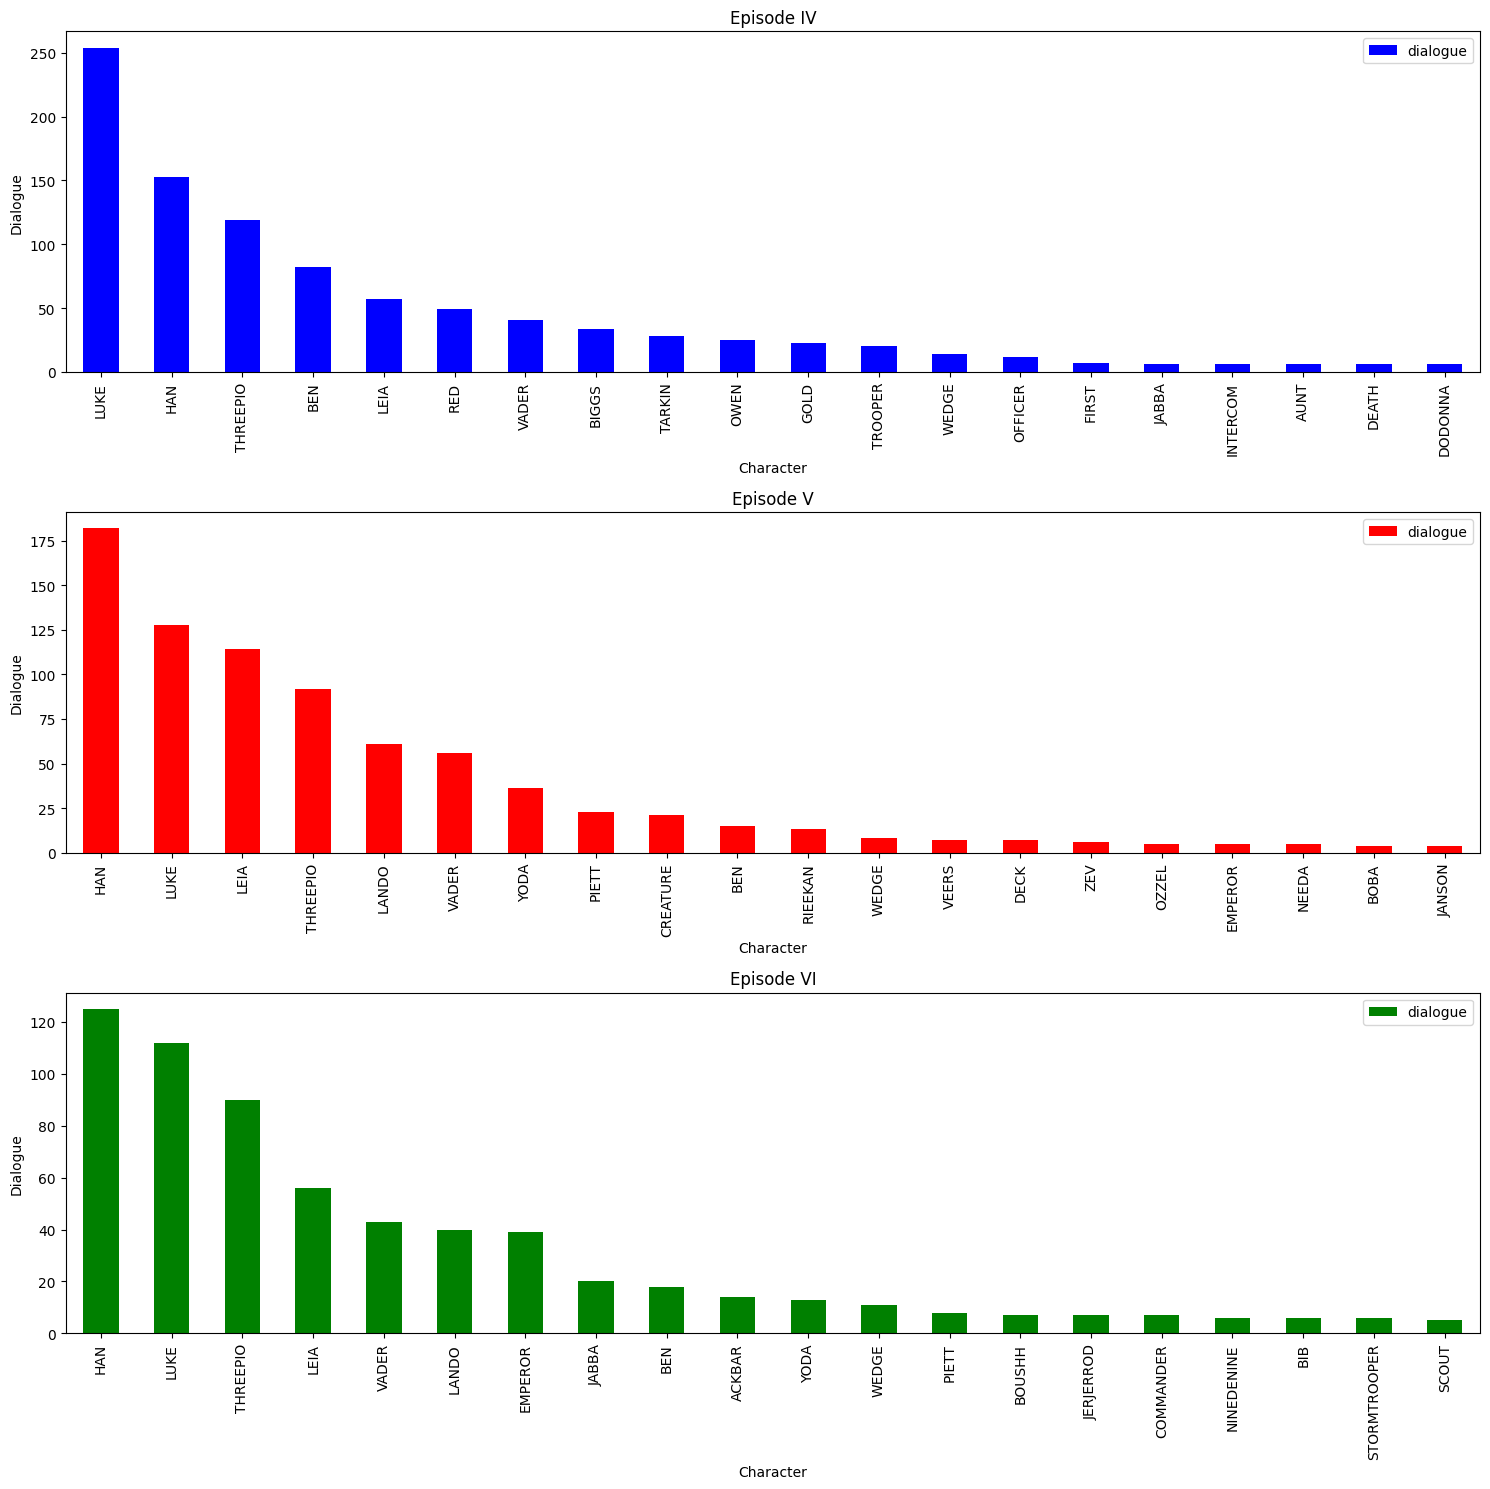

In [5]:
# create bar plots of top 20 characters in each episode
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
script_ep4.plot(ax=axs[0], kind='bar', x='character', y='dialogue', color='blue')
script_ep5.plot(ax=axs[1], kind='bar', x='character', y='dialogue', color='red')
script_ep6.plot(ax=axs[2], kind='bar', x='character', y='dialogue', color='green')

# set title and labels
axs[0].set_title('Episode IV')
axs[0].set_xlabel('Character')
axs[0].set_ylabel('Dialogue')
axs[1].set_title('Episode V')
axs[1].set_xlabel('Character')
axs[1].set_ylabel('Dialogue')
axs[2].set_title('Episode VI')
axs[2].set_xlabel('Character')
axs[2].set_ylabel('Dialogue')

# adjust layout and save plot
plt.tight_layout()
plt.savefig('top_characters.png')
plt.show()

In [7]:
# concatenate all dialogues into a single string
dialogue_str = ' '.join(df['dialogue'])

# convert string to lowercase
dialogue_str = dialogue_str.lower()

# tokenize string into individual words
tokens = word_tokenize(dialogue_str)

# count frequency distribution of words
freq_dist = Counter(tokens)

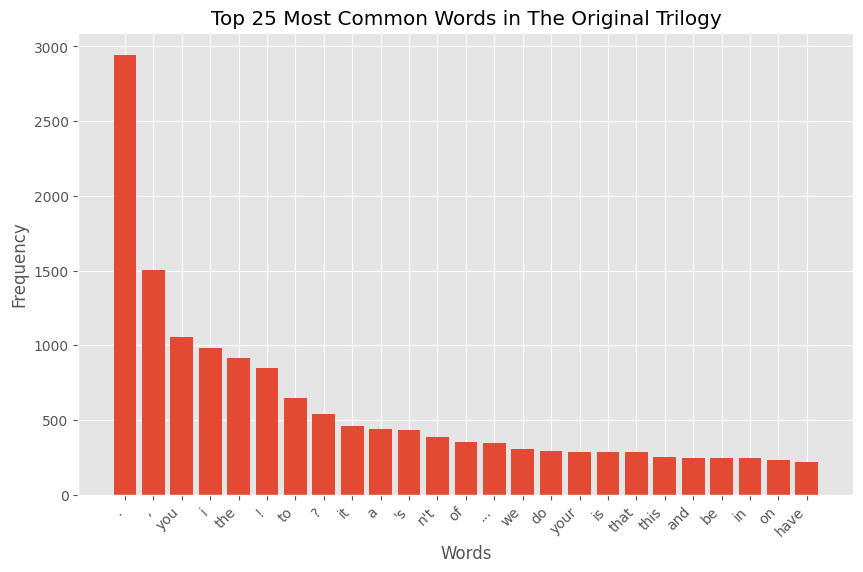

In [8]:
# create bar plot of top 20 most common words
style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.bar([i[0] for i in freq_dist.most_common(25)], [i[1] for i in freq_dist.most_common(25)])
plt.title('Top 25 Most Common Words in The Original Trilogy')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.savefig('top20_most_common_words_before.png')
plt.show()

In [11]:
lemmatizer = WordNetLemmatizer()

new_script = []
for dialogue in df.dialogue:
    dialogue = dialogue.lower() # lower case the whole text
    dialogue = re.sub("[^a-zA-Z]", " ", dialogue) # remove all the punctuations
    dialogue = nltk.word_tokenize(dialogue) # word tokenization
    dialogue = [token for token in dialogue if token not in stopwords.words('english')] # removing stopwords
    dialogue = [lemmatizer.lemmatize(token) for token in dialogue]
    dialogue = " ".join(dialogue)
    new_script.append(dialogue)

df["new_script"] = new_script
print(df)

     character                                           dialogue    episode  \
0     THREEPIO  Did you hear that?  They've shut down the main...  EpisodeIV   
1     THREEPIO                                      We're doomed!  EpisodeIV   
2     THREEPIO  There'll be no escape for the Princess this time.  EpisodeIV   
3     THREEPIO                                       What's that?  EpisodeIV   
4     THREEPIO  I should have known better than to trust the l...  EpisodeIV   
...        ...                                                ...        ...   
2518     LANDO       Wedge, I don't think we're going to make it.  EpisodeVI   
2519     WEDGE        You'll make it. Just follow me Gold Leader.  EpisodeVI   
2520     LANDO  I promised to return his ship without a scratc...  EpisodeVI   
2521       HAN                                           Lando...  EpisodeVI   
2522  THREEPIO                                       They did it!  EpisodeVI   

                                       

In [12]:
# concatenate all new_script into a single string
new_script_str = ' '.join(df['new_script'])

# tokenize string into individual words
tokens = word_tokenize(new_script_str)

# count frequency distribution of words
freq_dist = Counter(tokens)

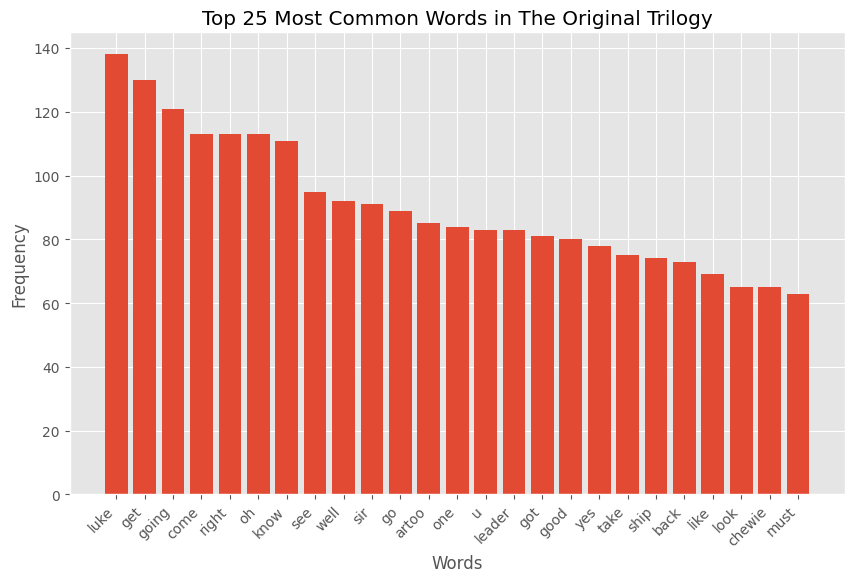

In [13]:
# create bar plot of top 20 most common words
style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.bar([i[0] for i in freq_dist.most_common(25)], [i[1] for i in freq_dist.most_common(25)])
plt.title('Top 25 Most Common Words in The Original Trilogy')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.savefig('top20_most_common_words_after.png')
plt.show()

In [14]:
# Filter the data for Darth Vader and Yoda's dialogues
vader = df[df.character == "VADER"]
yoda = df[df.character == "YODA"]

In [15]:
mask_vader= np.array(Image.open('./data/wordcloud_masks/vader.jpg'))
mask_yoda = np.array(Image.open('./data/wordcloud_masks/yoda.png'))

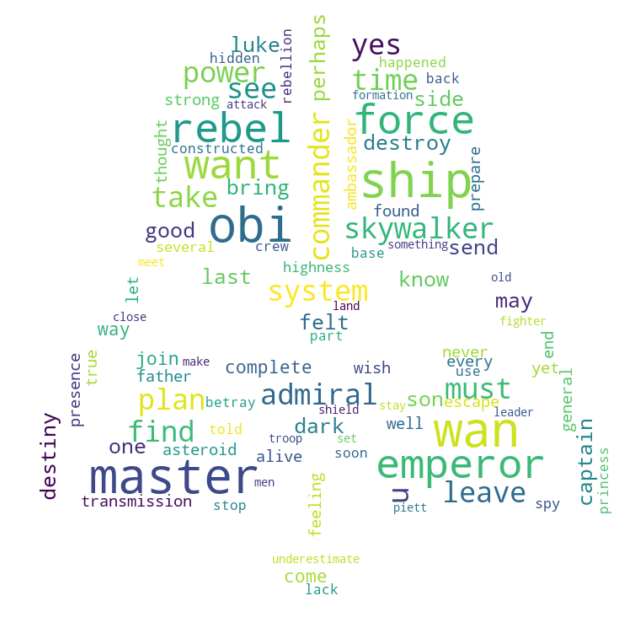

In [29]:
# Generate word clouds for the most common words spoken by Darth Vader
vader_words = " ".join(vader.new_script.values)
vader_freq_dist = nltk.FreqDist(nltk.word_tokenize(vader_words))
vader_top_words = vader_freq_dist.most_common(100)
vader_wordcloud_text = " ".join([word[0] for word in vader_top_words])

vader_wordcloud = WordCloud(width=800, height=800, background_color="white", mask=mask_vader, max_words=100).generate(vader_wordcloud_text)
plt.figure(figsize=(8,8))
plt.imshow(vader_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('vader_wordcloud.png')
plt.show()

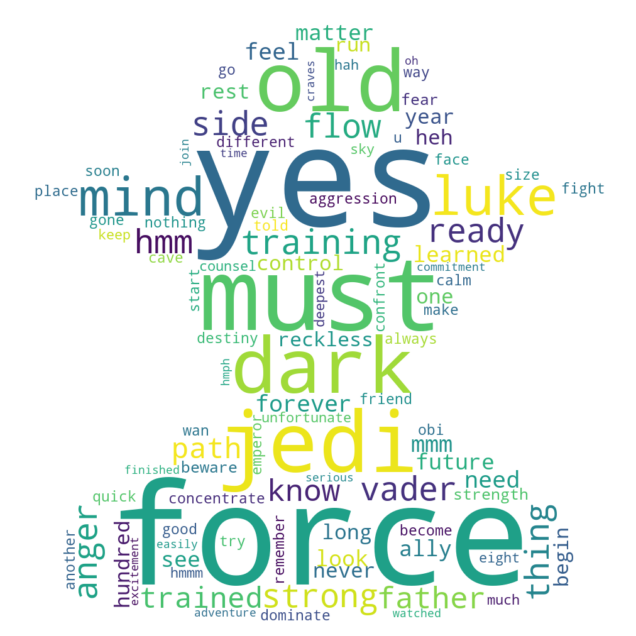

In [30]:
# Generate word clouds for the most common words spoken by Yoda
yoda_words = " ".join(yoda.new_script.values)
yoda_freq_dist = nltk.FreqDist(nltk.word_tokenize(yoda_words))
yoda_top_words = yoda_freq_dist.most_common(100)
yoda_wordcloud_text = " ".join([word[0] for word in yoda_top_words])

yoda_wordcloud = WordCloud(width=800, height=800, background_color="white", mask=mask_yoda, max_words=100).generate(yoda_wordcloud_text)
plt.figure(figsize=(8,8))
plt.imshow(yoda_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('yoda_wordcloud.png')
plt.show()

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# fit and transform the script to TF-IDF feature matrix
tfidf_matrix = tfidf.fit_transform(df['new_script'])

# get the feature names (words)
feature_names = tfidf.get_feature_names_out() 

# sum up the TF-IDF scores for each term over all documents
sum_scores = tfidf_matrix.sum(axis=0)

# convert the scores to a list of tuples (word, score) and sort them in descending order
scores = [(feature_names[col], sum_scores[0, col]) for col in range(tfidf_matrix.shape[1])]
scores = sorted(scores, key=lambda x: x[1], reverse=True)

# print the top 20 most relevant words
for word, score in scores[:20]:
    print(f"{word}: {score:.3f}")

luke: 49.903
right: 48.804
come: 47.430
going: 45.015
oh: 43.031
know: 40.568
yes: 39.542
leader: 34.739
artoo: 34.291
sir: 33.873
chewie: 30.869
got: 29.386
good: 28.093
let: 26.629
look: 26.018
like: 23.912
think: 23.889
ship: 23.556
help: 22.408
father: 21.954


In [21]:
# instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# define a function to get the sentiment score of a sentence
def get_sentiment_score(sentence):
    return sia.polarity_scores(sentence)['compound']

# apply the function to each dialogue in the dataset
df['sentiment_score'] = df['dialogue'].apply(get_sentiment_score)

# categorize the sentiment score into positive, neutral, or negative
def categorize_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

In [23]:
df

,character,dialogue,episode,new_script,sentiment_score,sentiment_category
0,THREEPIO,Did you hear that? They've shut down the main...,EpisodeIV,hear shut main reactor destroyed sure madness,-0.6239,negative
1,THREEPIO,We're doomed!,EpisodeIV,doomed,-0.6696,negative
2,THREEPIO,There'll be no escape for the Princess this time.,EpisodeIV,escape princess time,-0.1280,negative
3,THREEPIO,What's that?,EpisodeIV,,0.0000,neutral
4,THREEPIO,I should have known better than to trust the l...,EpisodeIV,known better trust logic half sized thermocaps...,0.7351,positive
...,...,...,...,...,...,...
2518,LANDO,"Wedge, I don't think we're going to make it.",EpisodeVI,wedge think going make,0.0000,neutral
2519,WEDGE,You'll make it. Just follow me Gold Leader.,EpisodeVI,make follow gold leader,0.0000,neutral
2520,LANDO,I promised to return his ship without a scratc...,EpisodeVI,promised return ship without scratch sure hope...,0.2100,positive
2521,HAN,Lando...,EpisodeVI,lando,0.0000,neutral


In [24]:
# This is a list created for the dark side and light side based on my own knowledge
dark_side = ['IMPERIAL', 'VADER', 'TROOPER', 'CHIEF', 'CAPTAIN', 
             'TAGGE', 'MOTTI', 'BARTENDER', 'CREATURE', 
             'GREEDO', 'JABBA', 'OFFICER', 'GANTRY', 'DEATH',
             'MASSASSI', 'NEEDA', 'EMPEROR', 'BOBA', 'TRACKING', 
             'JERJERROD', 'BIB', 'NINEDENINE', 'OOLA', 'BOUSHH', 
             'ANAKIN', 'LURE']
light_side = ['THREEPIO', 'LUKE', 'REBEL', 'WOMAN', 'FIXER', 'CAMIE', 
              'BIGGS', 'DEAK', 'LEIA', 'COMMANDER', 'SECOND', 'FIRST', 
              'BERU', 'OWEN', 'AUNT', 'BEN', 'VOICE', 'INTERCOM', 
              'WILLARD', 'DODONNA', 'GOLD', 'WEDGE', 'MAN', 'RED', 
              'PORKINS', 'ASTRO-OFFICER', 'CONTROL', 'WINGMAN', 'BASE', 
              'TECHNICIAN', 'YODA', 'LANDO', 'SHUTTLE', 'MON', 'ACKBAR', 
              'GENERAL', 'SCOUT', 'GUARD', 'GRAY', 'GREEN', 'STORMTROOPER', 
              'BUNKER', 'NAVIGATOR', 'Y-WING', 'WALKER', 'HAN', 'RIEEKAN', 
              'DECK', 'ASSISTANT', 'LIEUTENANT', 'DERLIN', 'ZEV', 'ANNOUNCER', 
              'SENIOR', 'PIETT', 'OZZEL', 'MEDICAL', 'CONTROLLER', 'VEERS', 
              'HOBBIE', 'PILOTS', 'DACK', 'TRENCH', 'JANSON', 'HEAD', 'PILOT', 
              'STRANGE', 'HAN/PILOT', 'TARKIN', 'HUMAN', 'COMMUNICATIONS', 
              'OPERATOR']


# Create new column indicating Dark Side or Light Side
df['side'] = df['character'].apply(lambda x: 'Dark Side' if x.upper() in dark_side else ('Light Side' if x.upper() in light_side else np.nan))
df

,character,dialogue,episode,new_script,sentiment_score,sentiment_category,side
0,THREEPIO,Did you hear that? They've shut down the main...,EpisodeIV,hear shut main reactor destroyed sure madness,-0.6239,negative,Light Side
1,THREEPIO,We're doomed!,EpisodeIV,doomed,-0.6696,negative,Light Side
2,THREEPIO,There'll be no escape for the Princess this time.,EpisodeIV,escape princess time,-0.1280,negative,Light Side
3,THREEPIO,What's that?,EpisodeIV,,0.0000,neutral,Light Side
4,THREEPIO,I should have known better than to trust the l...,EpisodeIV,known better trust logic half sized thermocaps...,0.7351,positive,Light Side
...,...,...,...,...,...,...,...
2518,LANDO,"Wedge, I don't think we're going to make it.",EpisodeVI,wedge think going make,0.0000,neutral,Light Side
2519,WEDGE,You'll make it. Just follow me Gold Leader.,EpisodeVI,make follow gold leader,0.0000,neutral,Light Side
2520,LANDO,I promised to return his ship without a scratc...,EpisodeVI,promised return ship without scratch sure hope...,0.2100,positive,Light Side
2521,HAN,Lando...,EpisodeVI,lando,0.0000,neutral,Light Side


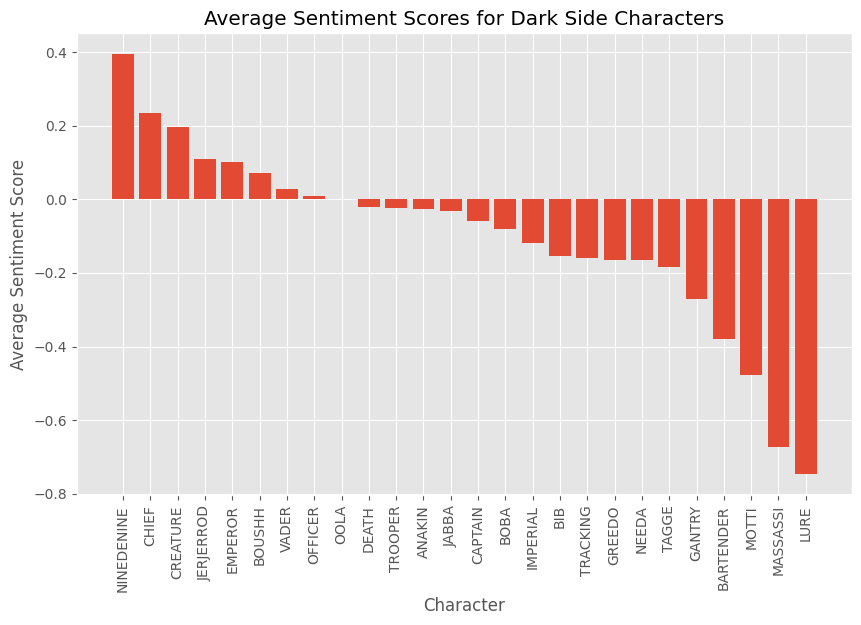

In [42]:
# calculate the mean sentiment score for each Dark Side character
mean_sentiment_scores = df[df["side"] == "Dark Side"].groupby("character")["sentiment_score"].mean().sort_values(ascending=False)

# plot the mean sentiment scores for each character
plt.figure(figsize=(10,6))
plt.bar(mean_sentiment_scores.index, mean_sentiment_scores.values)
plt.xticks(rotation=90)
plt.title("Average Sentiment Scores for Dark Side Characters")
plt.xlabel("Character")
plt.ylabel("Average Sentiment Score")
plt.savefig('Sentiment_Dark_Side.png', bbox_inches="tight")
plt.show()

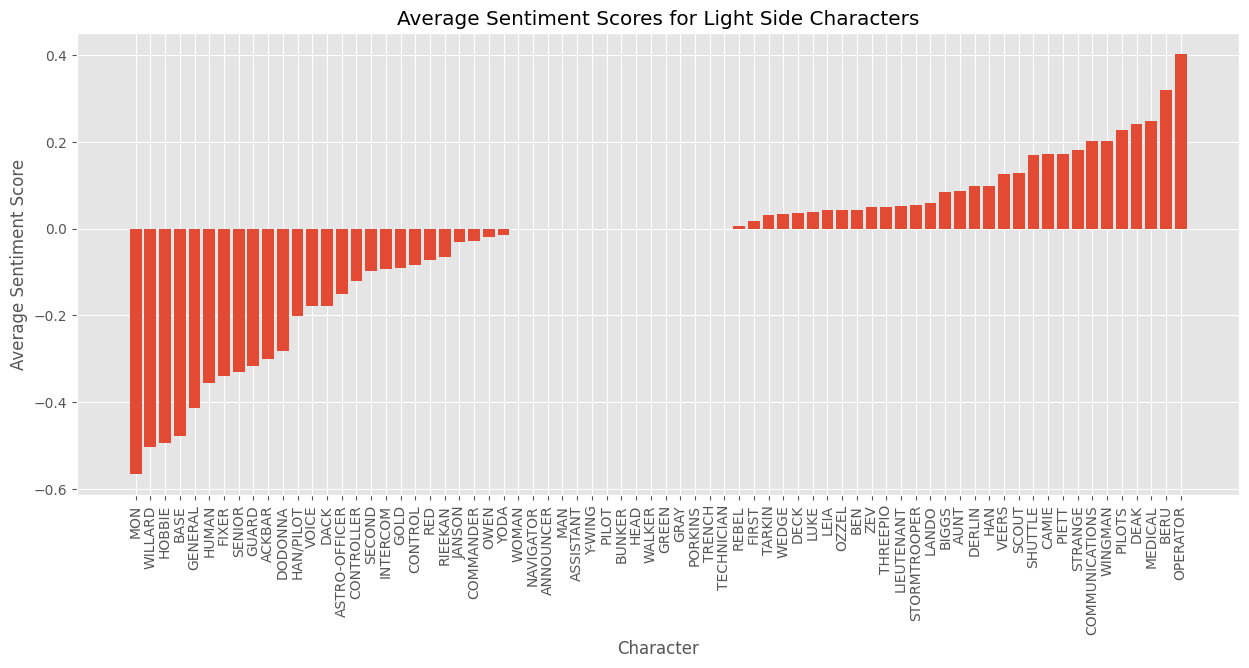

In [40]:
# calculate the mean sentiment score for each Dark Side character
mean_sentiment_scores = df[df["side"] == "Light Side"].groupby("character")["sentiment_score"].mean().sort_values(ascending=True)

# plot the mean sentiment scores for each character
plt.figure(figsize=(15,6))
plt.bar(mean_sentiment_scores.index, mean_sentiment_scores.values)
plt.xticks(rotation=90)
plt.title("Average Sentiment Scores for Light Side Characters")
plt.xlabel("Character")
plt.ylabel("Average Sentiment Score")
plt.savefig('Sentiment_Light_Side.png', bbox_inches="tight")
plt.show()

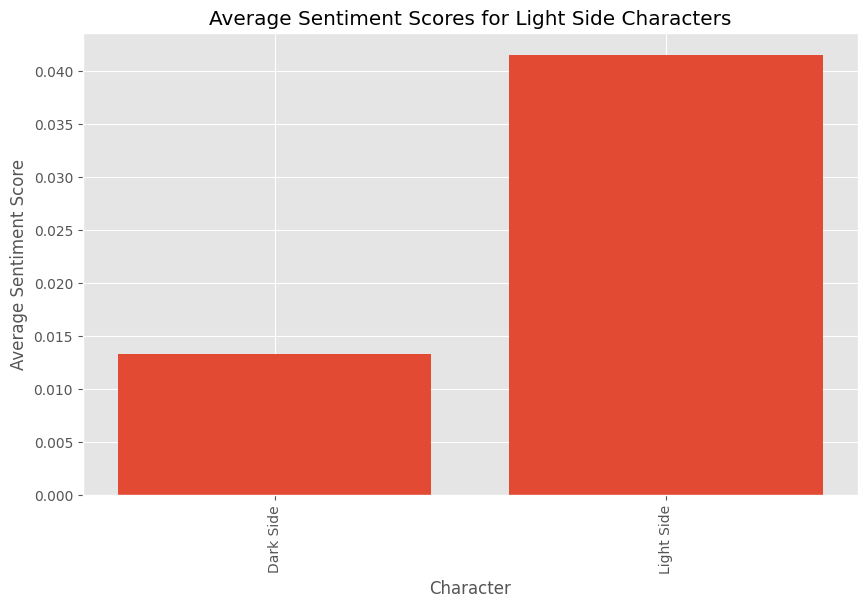

In [41]:
# calculate the mean sentiment score for each Dark Side character
mean_sentiment_scores = df.groupby("side")["sentiment_score"].mean()

# plot the mean sentiment scores for each character
plt.figure(figsize=(10,6))
plt.bar(mean_sentiment_scores.index, mean_sentiment_scores.values)
plt.xticks(rotation=90)
plt.title("Average Sentiment Scores for Light Side Characters")
plt.xlabel("Character")
plt.ylabel("Average Sentiment Score")
plt.savefig('Sentiment_Side_Average.png', bbox_inches="tight")
plt.show()